### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(12, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            # label.set_size(8)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "G"

In [7]:
df_G = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "G"].copy()
df_G

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
22,2021-01-07,SUMINI,BABULU DARAT,BABULU DARAT,BABULU,PEREMPUAN,1978-12-07,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,46
99,2021-01-27,BUDI,JL PERUM POLDA,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1974-02-01,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GF4,G,INDIVIDU,51
102,2021-01-28,"SAIPUL HOLIS, SE",JL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1969-10-18,Pegawai Swasta-Jasa,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SARJANA,GF4,G,INDIVIDU,55
172,2021-02-22,SULATI,JL BUKIT PELAJAR,BARU TENGAH,BALIKPAPAN BARAT,PEREMPUAN,1972-02-27,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,53
288,2021-03-23,SARINAH,BULUMINUNG,BULUMINUNG,PENAJAM,PEREMPUAN,1980-12-01,Pegawai Swasta-Pertanian,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,GF4,G,INDIVIDU,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6780,2024-08-21,PT JAYACOM PERSADA MANDIRI,JL MT HARYONO,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,2003-01-01,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,22
6790,2024-08-22,PT. ARKANANTA APTA PRATISTA,JL MT HARYONO,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,2006-08-22,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,18
6794,2024-08-23,AGUSWANTO,JL.SULAWESI,KARANG REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1972-07-08,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GF5,G,INDIVIDU,52
6803,2024-08-24,HENDRA TAMBA,JL KOLONEL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1990-01-05,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GD4,G,INDIVIDU,35


Plot data initial varian plus "G"

In [8]:
df_G_count = df_G[["Tgl. Mohon"]].copy()
df_G_count["count"] = 1.
df_G_count = df_G_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_G_count["cumulative_sum"] = df_G_count["count"].cumsum()
df_G_count["rolling_7days"] = df_G_count["count"].rolling(window=7, 
                                min_periods=1).sum()
df_G_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-07,1,1,1.0
1,2021-01-27,1,2,2.0
2,2021-01-28,1,3,3.0
3,2021-02-22,1,4,4.0
4,2021-03-23,1,5,5.0
...,...,...,...,...
171,2024-08-21,1,233,9.0
172,2024-08-22,1,234,9.0
173,2024-08-23,1,235,9.0
174,2024-08-24,1,236,7.0


Groub by weekly

In [9]:
df_G_weekly = df_G_count[["Tgl. Mohon"]].copy()
df_G_count["Tgl. Mohon"] = pd.to_datetime(df_G_count["Tgl. Mohon"])

df_G_weekly = (df_G.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_G_weekly["cumulative_sum"] = df_G_weekly["count"].cumsum()
df_G_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-11,1,1
1,2021-01-18,0,1
2,2021-01-25,0,1
3,2021-02-01,2,3
4,2021-02-08,0,3
...,...,...,...
186,2024-08-05,2,232
187,2024-08-12,0,232
188,2024-08-19,0,232
189,2024-08-26,4,236


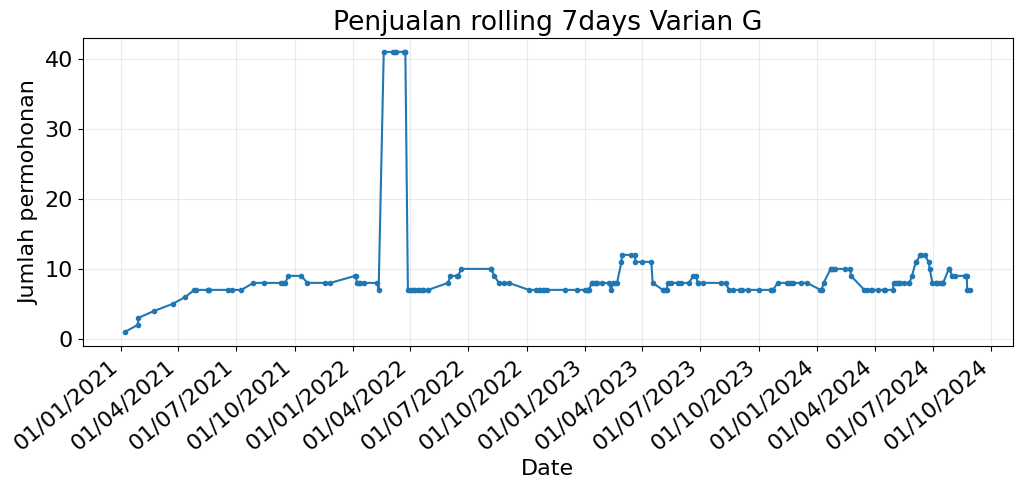

In [10]:
plot_time_series(df_G_count["Tgl. Mohon"], df_G_count["rolling_7days"], 
                title="Penjualan rolling 7days Varian G",
                xlabel="Date", ylabel="Jumlah permohonan")

In [11]:
Q1 = df_G_count["rolling_7days"].quantile(0.25)
Q3 = df_G_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_G_count[(df_G_count["rolling_7days"] < batas_bawah) | 
                      (df_G_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian G: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian G: 10


,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-07,1,1,1.0
1,2021-01-27,1,2,2.0
2,2021-01-28,1,3,3.0
32,2022-02-18,35,70,41.0
33,2022-03-04,1,71,41.0
34,2022-03-07,1,72,41.0
35,2022-03-09,1,73,41.0
36,2022-03-22,1,74,41.0
37,2022-03-23,1,75,41.0
38,2022-03-24,1,76,41.0


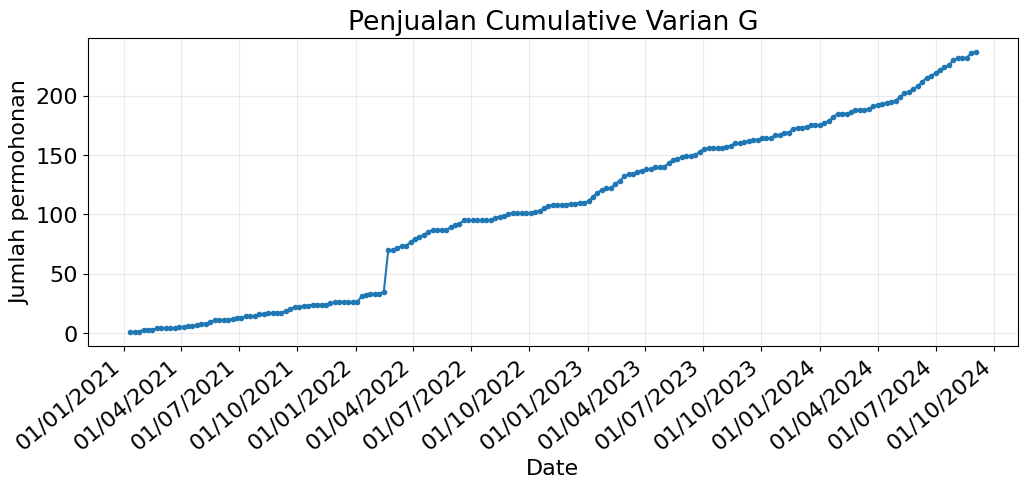

In [12]:
plot_time_series(df_G_weekly["Tgl. Mohon"], df_G_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian G",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [13]:
ADF_result = adfuller(df_G_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.901415185212702
p-value: 0.993108767112226


fisrt diff (_d_=1)

In [14]:
G_diff_week = np.diff(df_G_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(G_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -13.21378368994418
p-value: 1.0342962531778755e-24


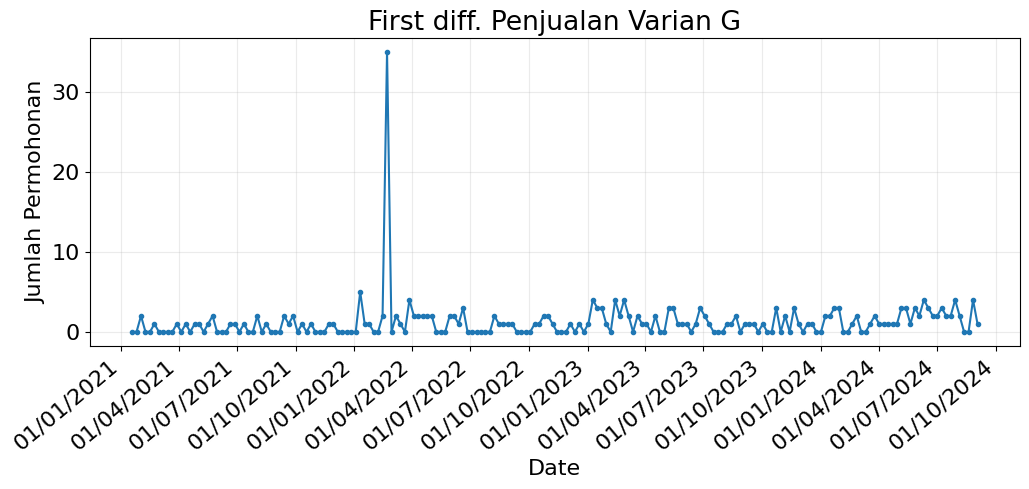

In [15]:
plot_time_series(df_G_weekly["Tgl. Mohon"].iloc[1:], G_diff_week, 
                 title="First diff. Penjualan Varian G",
                 xlabel="Date", ylabel="Jumlah Permohonan")

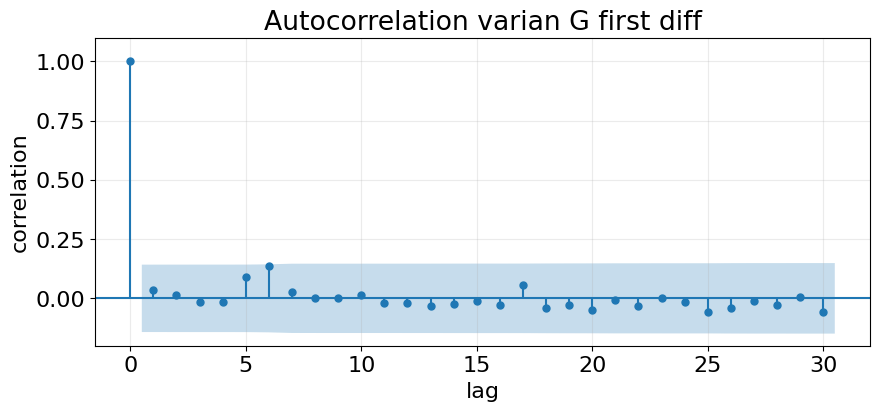

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(G_diff_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian G first diff")
ax.grid("on")

plt.show(fig)

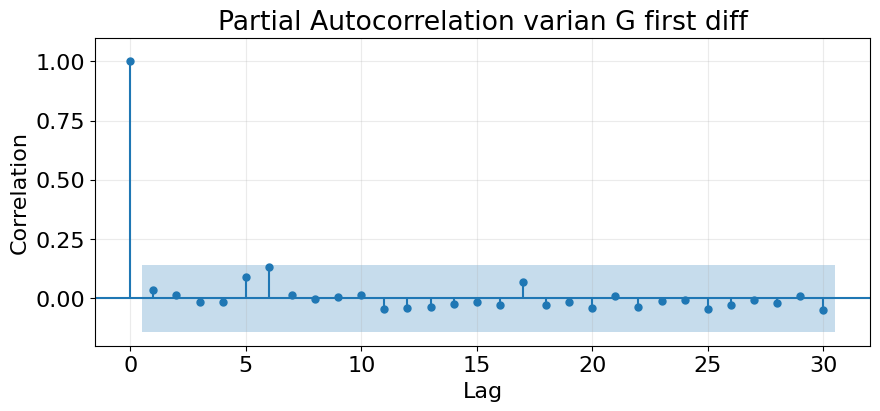

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(G_diff_week, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian G first diff")
ax.grid("on")

plt.show()

#### harian

In [18]:
ADF_result = adfuller(df_G_count["rolling_7days"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.574150796588493
p-value: 0.09845832175280544


In [19]:
G_diff = np.diff(df_G_count["rolling_7days"], n=1)
ADF_result = adfuller(G_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -5.731298562418629
p-value: 6.590814842324673e-07


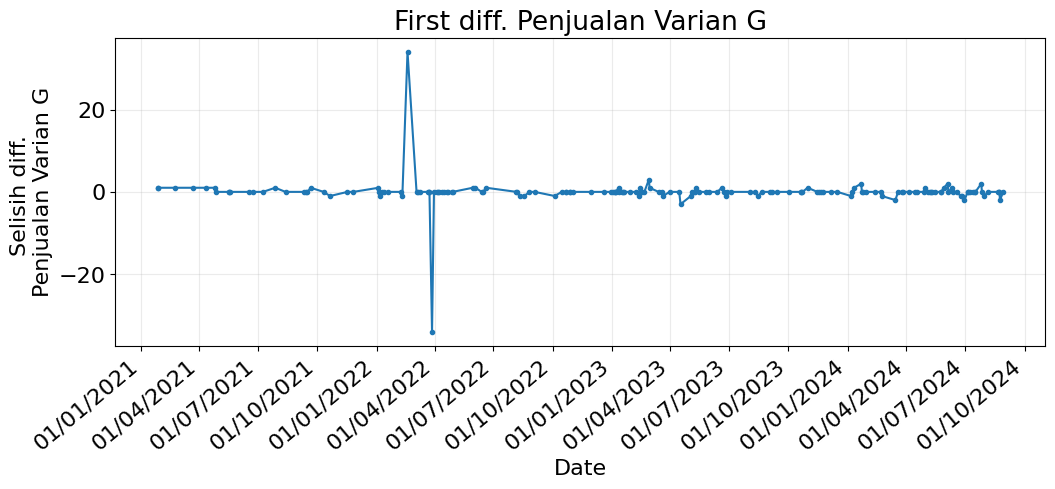

In [20]:
plot_time_series(df_G_count["Tgl. Mohon"].iloc[1:], G_diff, 
                 title="First diff. Penjualan Varian G",
                 xlabel="Date", ylabel="Selisih diff. \nPenjualan Varian G")

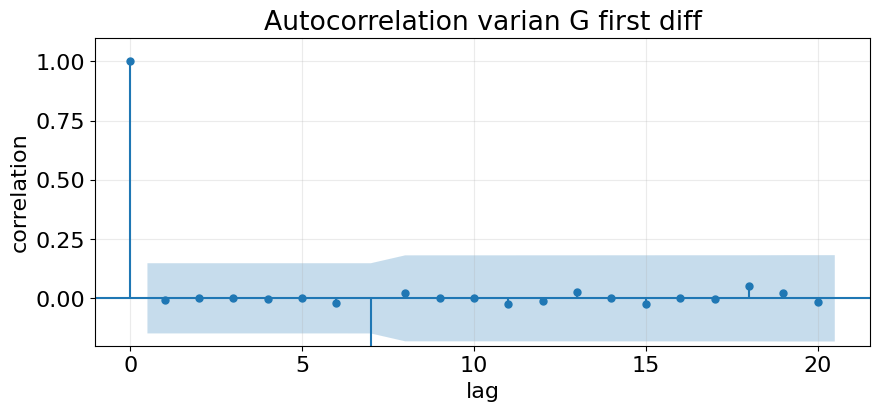

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(G_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian G first diff")
ax.grid("on")

plt.show(fig)

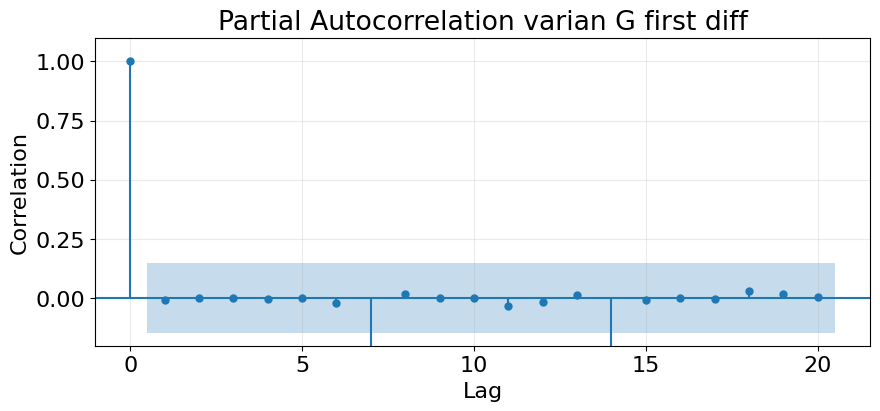

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(G_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian G first diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk

In [23]:
# --- Buat DataFrame baru untuk proses modeling --- #
df_model_G = df_G_count.copy().reset_index(drop=True)

# Buat kolom G_diff secara manual (dari np.diff)
df_model_G = df_model_G.iloc[1:].copy()  # karena np.diff mengurangi 1 baris
df_model_G["G_diff"] = G_diff

### Data Splitting

In [24]:
split_idx = int(len(df_model_G) * 0.8)
df_train = df_model_G.iloc[:split_idx].copy()
df_test = df_model_G.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")


(len(df_train), len(df_test)): (140, 35)


C:\Users\User\AppData\Local\Temp\ipykernel_6296\4251261687.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_6296\4251261687.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


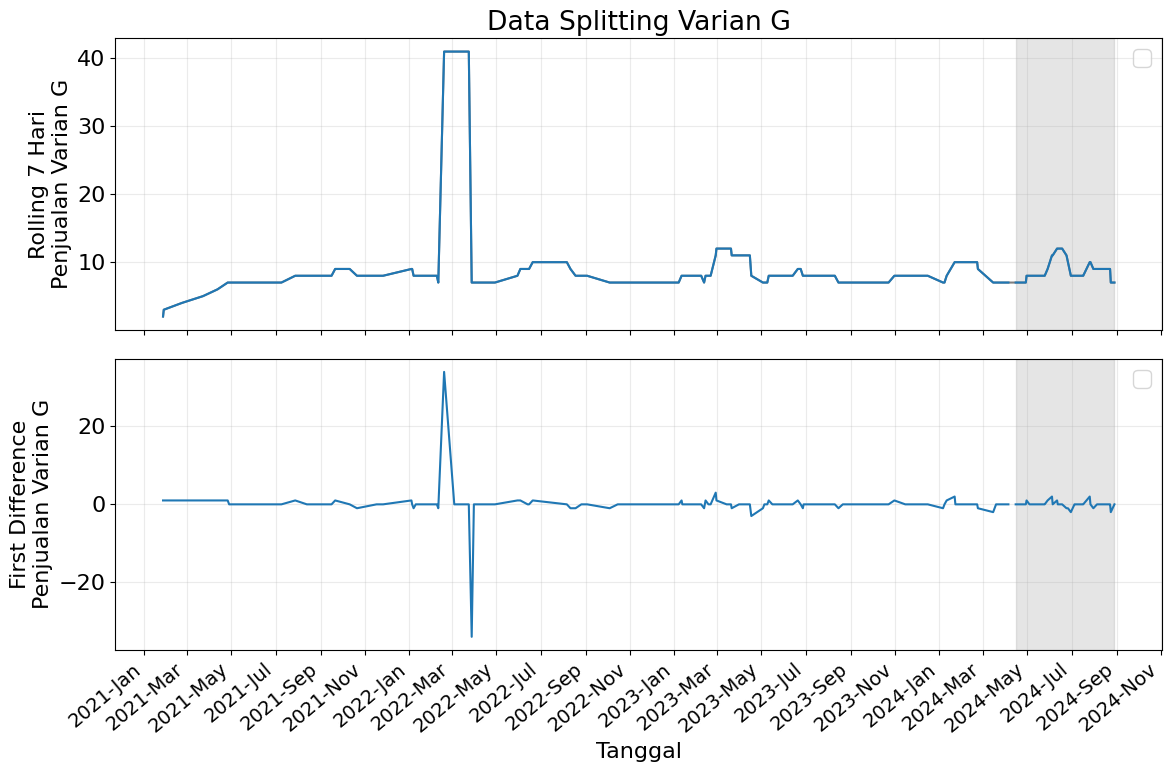

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# --- First Row: rolling_7days
axes[0].plot(df_model_G["Tgl. Mohon"], df_model_G["rolling_7days"], color="tab:gray")
axes[0].plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], color="tab:blue")
axes[0].plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue")
axes[0].set_ylabel("Rolling 7 Hari\nPenjualan Varian G")
axes[0].set_title("Data Splitting Varian G")
axes[0].legend()
axes[0].grid("on")

# Format tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# --- Second Row: G_diff
axes[1].plot(df_train["Tgl. Mohon"], df_train["G_diff"], color="tab:blue")
axes[1].plot(df_test["Tgl. Mohon"], df_test["G_diff"], color="tab:blue")
axes[1].set_xlabel("Tanggal")
axes[1].set_ylabel("First Difference\nPenjualan Varian G")
axes[1].legend()
axes[1].grid("on")

# Highlight test area
for j in range(2):
    axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                    color="gray", alpha=0.2, label="Forecast Area" if j == 0 else None)

# Rotate x-axis labels
for label in axes[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    label.set_fontsize(14)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_6296\2416349975.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


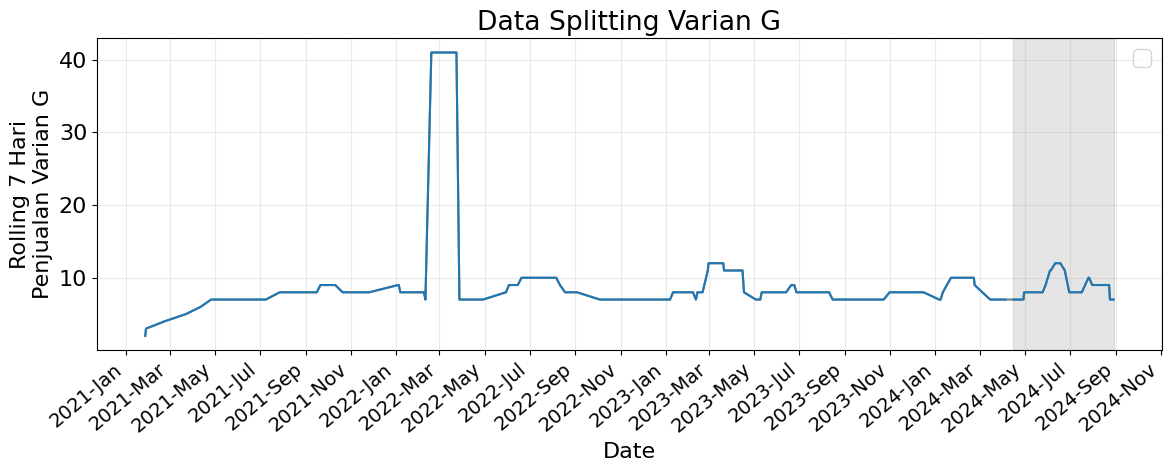

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

# --- Plot Rolling 7 Hari
ax.plot(df_model_G["Tgl. Mohon"], df_model_G["rolling_7days"], color="tab:gray")
ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], color="tab:blue")
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue")
ax.set_ylabel("Rolling 7 Hari\nPenjualan Varian G")
ax.set_xlabel("Date")
ax.set_title("Data Splitting Varian G")
ax.legend()
ax.grid("on")

# Highlight test area
ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
           color="gray", alpha=0.2, label="Forecast Area")

# Format tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# Rotate x-axis labels
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    label.set_fontsize(14)

plt.tight_layout()
plt.show()


### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [27]:
# --- Mean Forecast --- #
mean_train = np.mean(df_train["rolling_7days"])
df_test["pred_mean"] = mean_train

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,G_diff,pred_mean
141,2024-04-15,1,194,7.0,0.0,9.492857
142,2024-04-17,1,195,7.0,0.0,9.492857
143,2024-04-29,1,196,7.0,0.0,9.492857
144,2024-04-30,2,198,8.0,1.0,9.492857
145,2024-05-04,1,199,8.0,0.0,9.492857


In [28]:
# --- Last Value Forecast --- #
last_value = df_train["rolling_7days"].iloc[-1]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,G_diff,pred_mean,pred_last
141,2024-04-15,1,194,7.0,0.0,9.492857,7.0
142,2024-04-17,1,195,7.0,0.0,9.492857,7.0
143,2024-04-29,1,196,7.0,0.0,9.492857,7.0
144,2024-04-30,2,198,8.0,1.0,9.492857,7.0
145,2024-05-04,1,199,8.0,0.0,9.492857,7.0


In [29]:
# --- DRIFT Forecast --- #
y_i = df_train["G_diff"].iloc[0]
y_f = df_train["G_diff"].iloc[-1]
n_train = len(df_train)

drift = (y_f - y_i) / (n_train - 1)
print(f"Drift : {drift:}")

Drift : -0.007194244604316547


In [30]:
n_test = len(df_test)
pred_drift = [drift * t + y_i for t in range(1, n_test + 1)]
df_test["pred_drift"] = pred_drift

df_test.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,G_diff,pred_mean,pred_last,pred_drift
141,2024-04-15,1,194,7.0,0.0,9.492857,7.0,0.992806
142,2024-04-17,1,195,7.0,0.0,9.492857,7.0,0.985612
143,2024-04-29,1,196,7.0,0.0,9.492857,7.0,0.978417
144,2024-04-30,2,198,8.0,1.0,9.492857,7.0,0.971223
145,2024-05-04,1,199,8.0,0.0,9.492857,7.0,0.964029


In [31]:
# Inverse differencing ke rolling_7days
last_rolling_train = df_train["rolling_7days"].iloc[-1]
pred_drift_rolling = [last_rolling_train + sum(pred_drift[:i+1]) for i in range(n_test)]
df_test["pred_drift_rolling"] = pred_drift_rolling

# --- Evaluation --- #
true_rolling = df_test["rolling_7days"].values

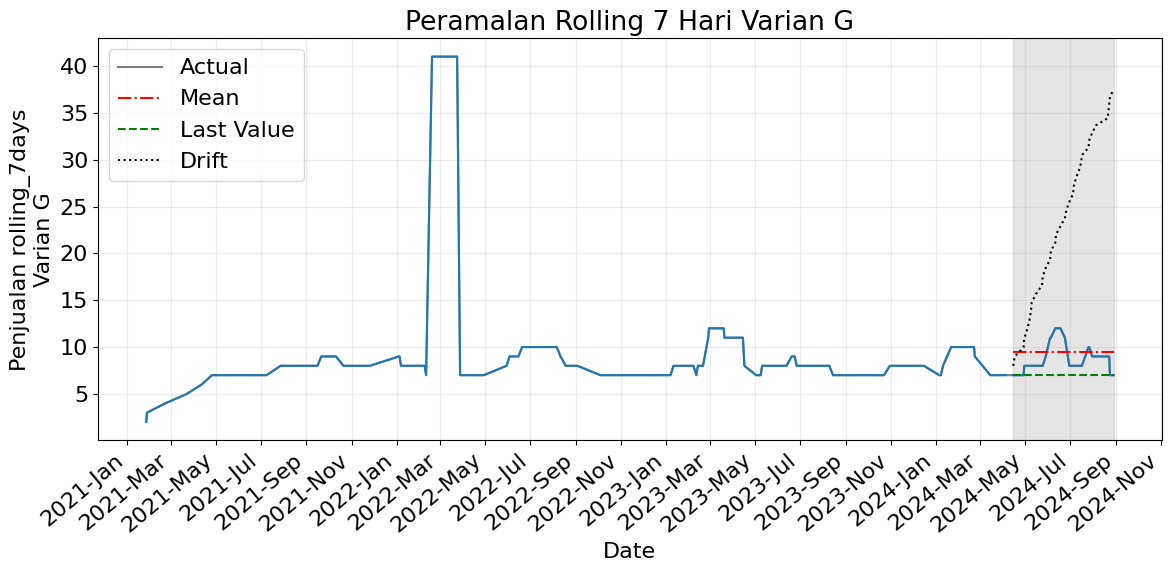

In [32]:
# Visualisasi hasil forecast
fig, ax = plt.subplots(figsize=(12, 6))

# --- Data aktual
ax.plot(df_model_G["Tgl. Mohon"], df_model_G["rolling_7days"], color="tab:gray", label="Actual")
ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"], color="tab:blue")
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue")

# --- Hasil Forecast
ax.plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="Mean")
ax.plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="Last Value")
ax.plot(df_test["Tgl. Mohon"], df_test["pred_drift_rolling"], "k:", label="Drift")

# --- Highlight test/forecast area
ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], color="gray", alpha=0.2)

# --- Format sumbu tanggal
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# --- Format sumbu dan label
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling_7days\nVarian G")
ax.set_title("Peramalan Rolling 7 Hari Varian G")
ax.legend()
ax.grid(True)

# --- Rotate tanggal agar mudah dibaca
for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment("right")
    # label.set_fontsize(12)

plt.tight_layout()
plt.show()


### Evaluasi

MAE

In [33]:
mae_pred_mean   = mean_absolute_error(true_rolling, df_test["pred_mean"])
mae_pred_last   = mean_absolute_error(true_rolling, df_test["pred_last"])
mae_pred_drift  = mean_absolute_error(true_rolling, df_test["pred_drift_rolling"])

print(f"MAE mean: {mae_pred_mean}")
print(f"MAE last: {mae_pred_last}")
print(f"MAE drif: {mae_pred_drift}")

MAE mean: 1.467959183673469
MAE last: 1.8
MAE drif: 14.602877697841727


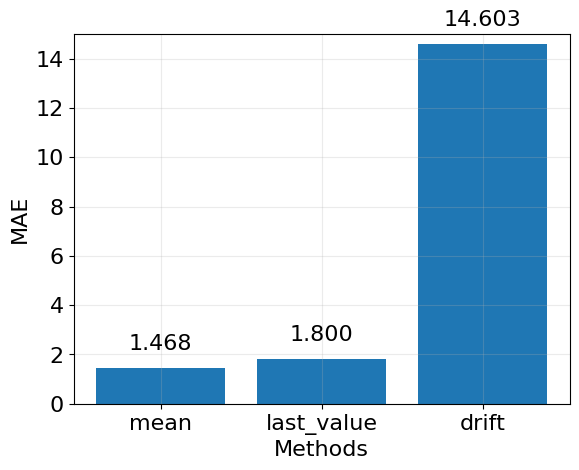

In [34]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [35]:
mse_pred_mean  = mean_squared_error(true_rolling, df_test["pred_mean"])
mse_pred_last  = mean_squared_error(true_rolling, df_test["pred_last"])
mse_pred_drift = mean_squared_error(true_rolling, df_test["pred_drift_rolling"])

print(f"MSE mean: {mse_pred_mean}")
print(f"MSE last: {mse_pred_last}")
print(f"MSE drif: {mse_pred_drift}")

MSE mean: 2.6400510204081624
MSE last: 5.4
MSE drif: 288.48375342891165


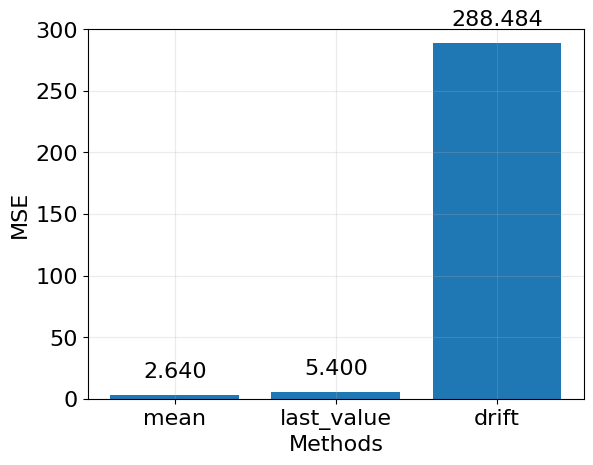

In [36]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 300])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [37]:
rmse_pred_mean  = np.sqrt(mse_pred_mean)
rmse_pred_last  = np.sqrt(mse_pred_last)
rmse_pred_drift = np.sqrt(mse_pred_drift)

print(f"RMSE mean: {rmse_pred_mean}")
print(f"RMSE last: {rmse_pred_last}")
print(f"RMSE drif: {rmse_pred_drift}")

RMSE mean: 1.6248233812966142
RMSE last: 2.32379000772445
RMSE drif: 16.984809490509797


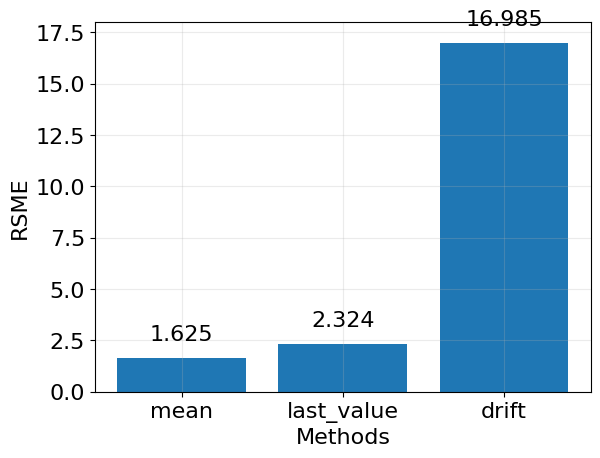

In [38]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 18])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [39]:
mape_pred_mean  = mean_absolute_percentage_error(true_rolling, df_test["pred_mean"]) * 100
mape_pred_last  = mean_absolute_percentage_error(true_rolling, df_test["pred_last"]) * 100
mape_pred_drift = mean_absolute_percentage_error(true_rolling, df_test["pred_drift_rolling"]) * 100

print(f"MAPE mean: {mape_pred_mean:5.2f}%")
print(f"MAPE last: {mape_pred_last:5.2f}%")
print(f"MAPE drift: {mape_pred_drift:5.2f}%")

MAPE mean: 17.42%
MAPE last: 18.43%
MAPE drift: 169.81%


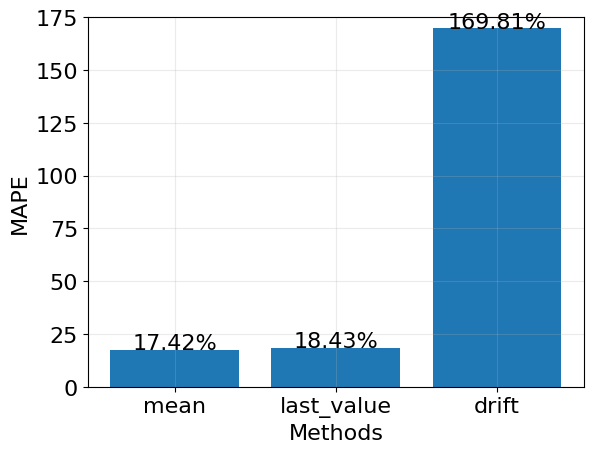

In [40]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 175])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [41]:
naive = np.abs(np.diff(df_train["rolling_7days"])).mean()
mase_pred_mean  = mae_pred_mean / naive
mase_pred_last  = mae_pred_last / naive
mase_pred_drift = mae_pred_drift / naive

print(f"MASE mean: {mase_pred_mean}")
print(f"MASE last: {mase_pred_last}")
print(f"MASE drift: {mase_pred_drift}")

MASE mean: 1.8719846470698365
MASE last: 2.295412844036697
MASE drift: 18.622018348623854


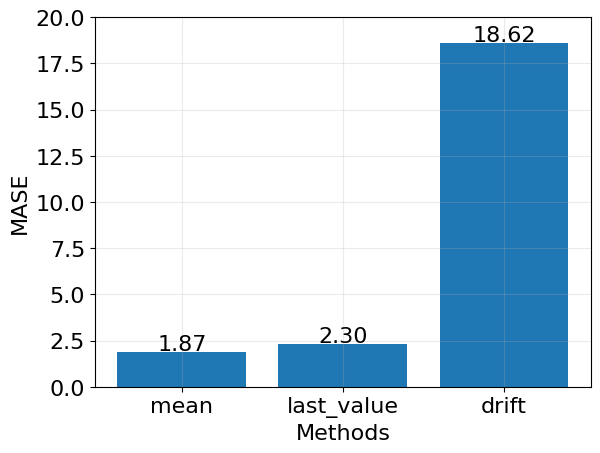

In [42]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

gaada lag yang signifikan pada acf dan pacf = random walk

### Data Splitting

In [43]:
min_length = min(len(df_G_count["Tgl. Mohon"].iloc[1:]), len(G_diff))

df_H_diff = pd.DataFrame({
    "Tgl. Mohon": df_G_count["Tgl. Mohon"].iloc[1:min_length+1].values,
    "G_diff": G_diff[:min_length]
})

split_idx = int(0.8 * len(df_H_diff))
df_train = df_H_diff.iloc[:split_idx].copy()
df_test = df_H_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (140, 35)


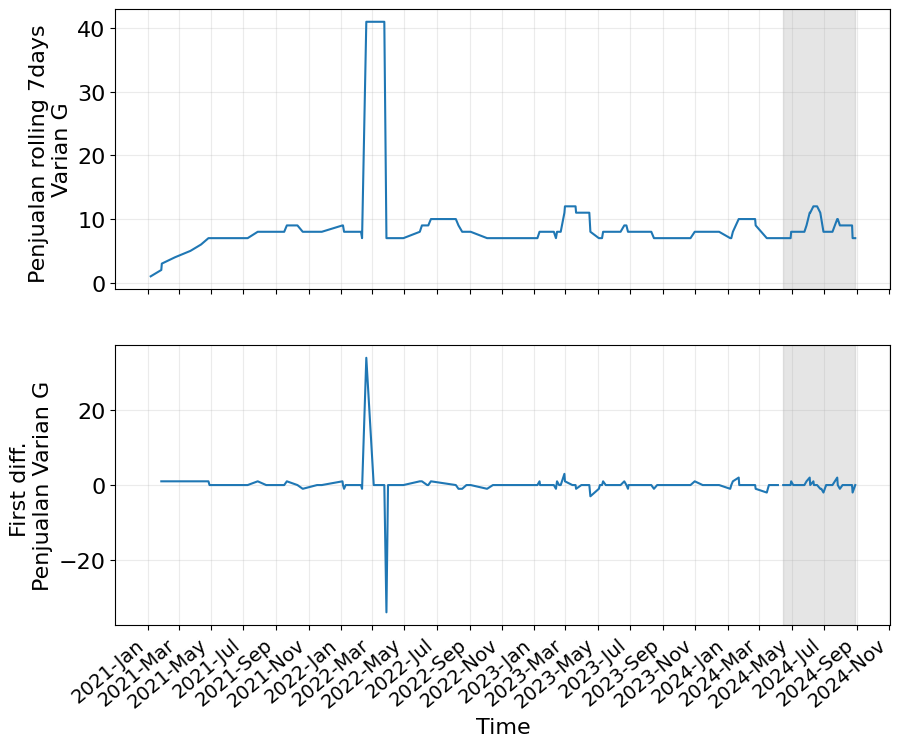

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_G_count["Tgl. Mohon"], df_G_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian G")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["G_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["G_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian G")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [45]:
mean_train_random_walk = np.mean(df_train["G_diff"])
df_test["pred_mean"] = mean_train_random_walk

df_test.head()

,Tgl. Mohon,G_diff,pred_mean
140,2024-04-15,0.0,0.042857
141,2024-04-17,0.0,0.042857
142,2024-04-29,0.0,0.042857
143,2024-04-30,1.0,0.042857
144,2024-05-04,0.0,0.042857


In [46]:
last_value = df_train.iloc[-1]["G_diff"]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,G_diff,pred_mean,pred_last
140,2024-04-15,0.0,0.042857,0.0
141,2024-04-17,0.0,0.042857,0.0
142,2024-04-29,0.0,0.042857,0.0
143,2024-04-30,1.0,0.042857,0.0
144,2024-05-04,0.0,0.042857,0.0


In [47]:
y_i = df_train["G_diff"].iloc[0]
y_f = df_train["G_diff"].iloc[-1]
h_y = y_f - y_i
h_x = len(df_train) - 1
drift = h_y / h_x

print(f"drift = {drift}")

drift = -0.007194244604316547


In [48]:
x_vals = np.arange(1, len(df_test) + 1)
df_test["pred_drift"] = drift * x_vals + y_i

df_test.head()

,Tgl. Mohon,G_diff,pred_mean,pred_last,pred_drift
140,2024-04-15,0.0,0.042857,0.0,0.992806
141,2024-04-17,0.0,0.042857,0.0,0.985612
142,2024-04-29,0.0,0.042857,0.0,0.978417
143,2024-04-30,1.0,0.042857,0.0,0.971223
144,2024-05-04,0.0,0.042857,0.0,0.964029


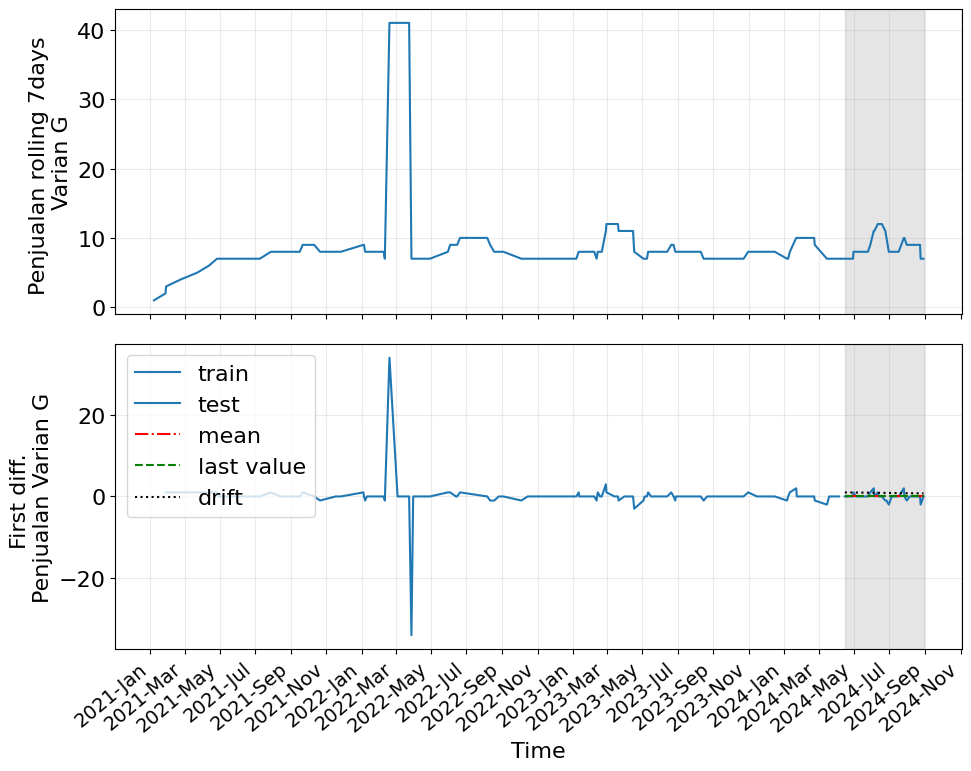

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row: rolling_7days
axes[0].plot(df_G_count["Tgl. Mohon"], df_G_count["rolling_7days"], label="rolling_7days")
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian G")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row: G_diff + predictions
axes[1].plot(df_train["Tgl. Mohon"], df_train["G_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["G_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian G")
axes[1].grid("on")
axes[1].legend()

# add forecast area
for j in range(2):
    axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2)

# rotate labels
for j, label in enumerate(axes[1].get_xticklabels()):
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show(fig)


In [50]:
# Ambil nilai rolling_7days terakhir dari data latih
last_rolling_train = df_G_count["rolling_7days"].iloc[len(df_train)]

# Tambahkan hasil forecast asli (bukan differencing)
df_test["forecast_mean"]  = last_rolling_train + df_test["pred_mean"].cumsum()
df_test["forecast_last"]  = last_rolling_train + df_test["pred_last"].cumsum()
df_test["forecast_drift"] = last_rolling_train + df_test["pred_drift"].cumsum()

# Gabungkan nilai aktual rolling_7days
df_test = df_test.merge(df_G_count[["Tgl. Mohon", "rolling_7days"]], on="Tgl. Mohon", how="left")


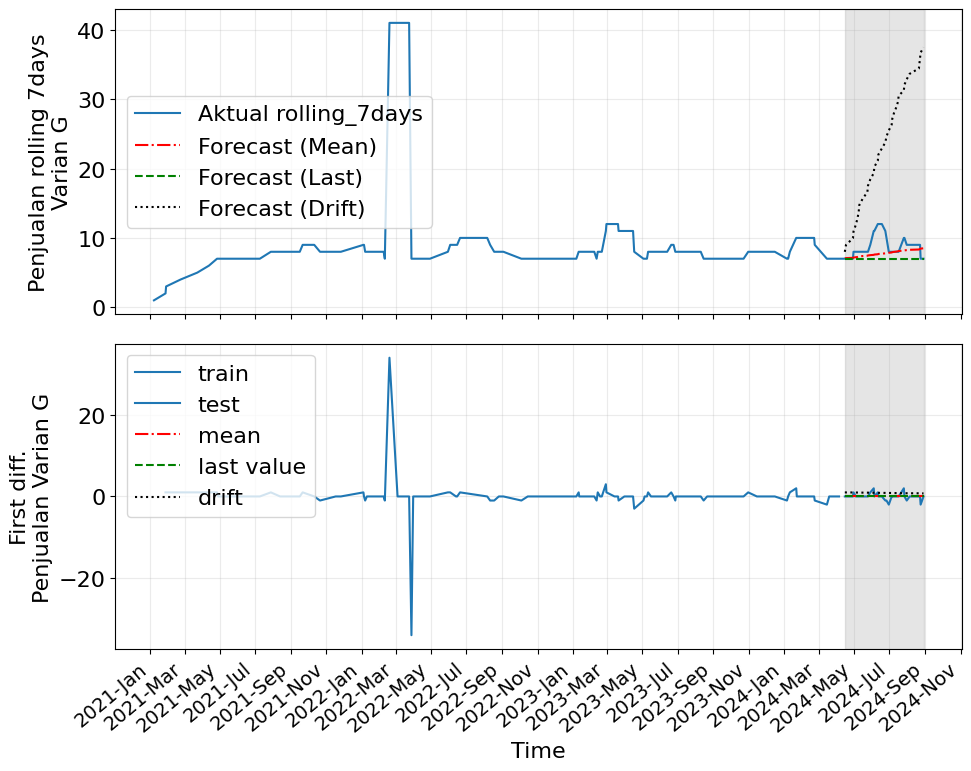

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- subplot 1: rolling_7days aktual + hasil forecast
axes[0].plot(df_G_count["Tgl. Mohon"], df_G_count["rolling_7days"], label="Aktual rolling_7days")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_mean"], "r-.", label="Forecast (Mean)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_last"], "g--", label="Forecast (Last)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_drift"], "k:", label="Forecast (Drift)")
axes[0].set_ylabel("Penjualan rolling 7days\nVarian G")
axes[0].legend()
axes[0].grid(True)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- subplot 2: G_diff dan prediksi differenced
axes[1].plot(df_train["Tgl. Mohon"], df_train["G_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["G_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff.\nPenjualan Varian G")
axes[1].grid(True)
axes[1].legend()

# -- shading area test
for ax in axes:
    ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
               color="#808080", alpha=0.2)

# -- format x-axis
for label in axes[1].get_xticklabels():
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


### Evaluasi

In [52]:
mae_pred_mean  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_mean"])
mae_pred_last  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_last"])
mae_pred_drift = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MAE mean:  {mae_pred_mean:.2f}")
print(f"MAE last:  {mae_pred_last:.2f}")
print(f"MAE drift: {mae_pred_drift:.2f}")

MAE mean:  1.22
MAE last:  1.80
MAE drift: 14.60


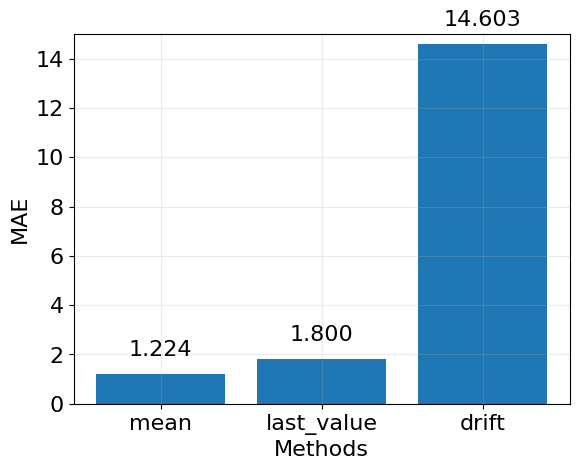

In [53]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [54]:
mse_pred_mean  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_mean"])
mse_pred_last  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_last"])
mse_pred_drift = mean_squared_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MSE mean:  {mse_pred_mean:.2f}")
print(f"MSE last:  {mse_pred_last:.2f}")
print(f"MSE drift: {mse_pred_drift:.2f}")

MSE mean:  3.25
MSE last:  5.40
MSE drift: 288.48


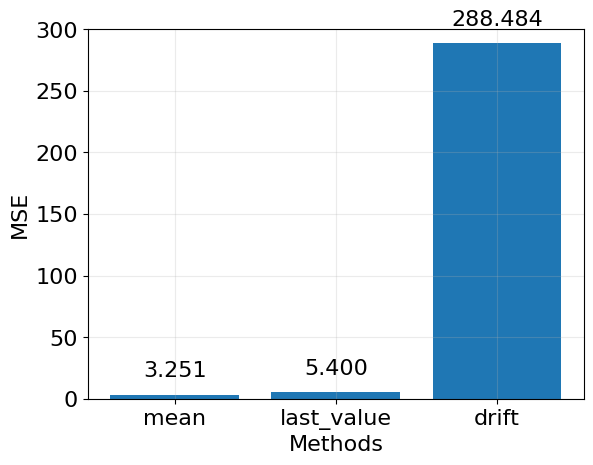

In [55]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 300])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [56]:
rmse_pred_mean  = np.sqrt(mse_pred_mean)
rmse_pred_last  = np.sqrt(mse_pred_last)
rmse_pred_drift = np.sqrt(mse_pred_drift)

print(f"RMSE mean:  {rmse_pred_mean:.2f}")
print(f"RMSE last:  {rmse_pred_last:.2f}")
print(f"RMSE drift: {rmse_pred_drift:.2f}")

RMSE mean:  1.80
RMSE last:  2.32
RMSE drift: 16.98


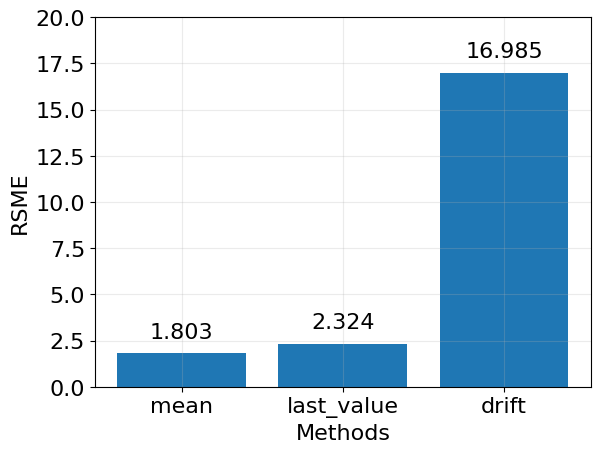

In [57]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [58]:
mape_pred_mean  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_mean"]) * 100
mape_pred_last  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_last"]) * 100
mape_pred_drift = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_drift"]) * 100

print(f"MAPE mean:  {mape_pred_mean:.2f}%")
print(f"MAPE last:  {mape_pred_last:.2f}%")
print(f"MAPE drift: {mape_pred_drift:.2f}%")

MAPE mean:  12.34%
MAPE last:  18.43%
MAPE drift: 169.81%


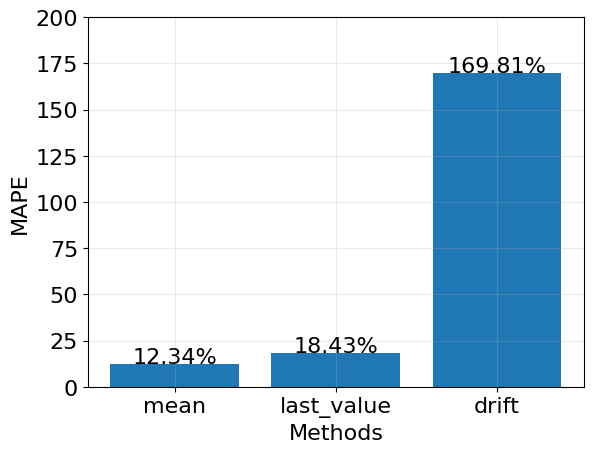

In [59]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 200])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [60]:
mase_pred_mean  = mae_pred_mean / naive
mase_pred_last  = mae_pred_last / naive
mase_pred_drift = mae_pred_drift / naive

print(f"MASE mean:  {mase_pred_mean:.2f}")
print(f"MASE last:  {mase_pred_last:.2f}")
print(f"MASE drift: {mase_pred_drift:.2f}")

MASE mean:  1.56
MASE last:  2.30
MASE drift: 18.62


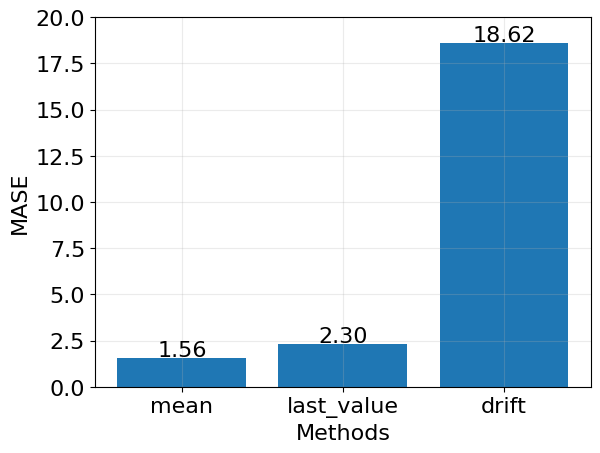

In [61]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)